This notebook contains sentiment a analysis task using two types of deep neural network, namely RNNs and CNNs and compare the results. 
The [Amazon review dataset](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews) is used for sentiment analysis. The pre-processed dataset can be found in the directory /datasets/amazon-reviews/, divided into training, validation and test sets. The dataset has been adapted so that there is a rating of 0=negative and 1=positive for each review document.

## Importing the required libraries

In [1]:
import numpy as np
import tensorflow as tf
import json

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
%matplotlib inline

## Creating some constants - Provided by the OU


In [2]:
BATCH_SIZE = 512

In [3]:
METRICS = [
      lambda : tf.keras.metrics.TruePositives(name='tp'),
      lambda : tf.keras.metrics.FalsePositives(name='fp'),
      lambda : tf.keras.metrics.TrueNegatives(name='tn'),
      lambda : tf.keras.metrics.FalseNegatives(name='fn'), 

      lambda : tf.keras.metrics.Accuracy(name='accuracy'),
      lambda : tf.keras.metrics.Precision(name='precision'),
      lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## Loading the data

In [4]:
train_filename = '/datasets/amazon-reviews/train.csv'
val_filename = '/datasets/amazon-reviews/validation.csv'
test_filename = '/datasets/amazon-reviews/test.csv'

In [5]:
train_data = tf.data.experimental.make_csv_dataset(train_filename, batch_size=BATCH_SIZE, num_epochs=1)
train_data = train_data.map(lambda d: (d['Review'], d['Rating']))

In [6]:
# take 10% of the training data
train_data10 = train_data.shard(10, 0)

train_data10 = train_data10.cache()
train_data10 = train_data10.shuffle(50000)
train_data10 = train_data10.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [7]:
# take 25% of the training data
train_data25 = train_data.shard(4, 0)

train_data25 = train_data25.cache()
train_data25 = train_data25.shuffle(50000)
train_data25 = train_data25.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [8]:
# take 50% of the training data
train_data50 = train_data.shard(2, 0)

train_data50 = train_data50.cache()
train_data50 = train_data50.shuffle(50000)
train_data50 = train_data50.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [9]:
# use all the training data
train_data = train_data.cache()
train_data = train_data.shuffle(50000)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [10]:
validation_data = tf.data.experimental.make_csv_dataset(val_filename, batch_size=BATCH_SIZE, num_epochs=1)
validation_data = validation_data.map(lambda d: (d['Review'], d['Rating']))
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [11]:
test_data = tf.data.experimental.make_csv_dataset(test_filename, batch_size=BATCH_SIZE, num_epochs=1)
test_data = test_data.map(lambda d: (d['Review'], d['Rating']))
test_data = test_data.cache()
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating text encoders - Provided by the OU

The following code creates and saves text encoders for different vocabulary sizes (100, 200 and 300 in this TMA). Running this code will take some time, but this saves the files for use later.


In [12]:
!mkdir encoder100
!mkdir encoder200
!mkdir encoder300

mkdir: cannot create directory ‘encoder100’: File exists
mkdir: cannot create directory ‘encoder200’: File exists
mkdir: cannot create directory ‘encoder300’: File exists


### Create, adapt, and save an encoder

You will only need to do this once. You may like to comment out the code in these cells after the first run.

In [12]:
encoder = tf.keras.layers.TextVectorization(max_tokens=100)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder100')

In [13]:
encoder = tf.keras.layers.TextVectorization(max_tokens=200)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder200')

In [14]:
encoder = tf.keras.layers.TextVectorization(max_tokens=300)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder300')

### Create an encoder and load its assets from file

In [12]:
encoder100 = tf.keras.layers.TextVectorization(max_tokens=100)
encoder100.load_assets('encoder100')

In [13]:
encoder200 = tf.keras.layers.TextVectorization(max_tokens=200)
encoder200.load_assets('encoder200')

In [14]:
encoder300 = tf.keras.layers.TextVectorization(max_tokens=300)
encoder300.load_assets('encoder300')

### LSTM models with varying size of vobabulary and  length of word embedding vectors.

3 models:

* LSTM_model_1: with 4 LSTM units, using 200-word encoder, word embedding length of 16 
* LSTM_model_2: with 4 LSTM units, using 300-word encoder, word embedding length of 16
* LSTM_model_3: with 4 LSTM units, using 300-word encoder, word embedding length of 32 




## Build and train the required LSTM models

In [ ]:
# model 1, 4 LSTM units, 200 word encoder, embedding length of 16
EMBEDDING_LEN_model_1 = 16
LSTM_model_1 = Sequential([
    encoder200, 
    Embedding(input_dim=len(encoder200.get_vocabulary()), output_dim=EMBEDDING_LEN_model_1, mask_zero=True),
    LSTM(4), 
    Dense(1, activation='sigmoid')
])

# model 2, 4 LSTM units, 300 word encoder, embedding length of 16
EMBEDDING_LEN_model_2 = 16
LSTM_model_2 = Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN_model_2, mask_zero=True),
    LSTM(4), 
    Dense(1, activation='sigmoid') 
])

# model 3, 4 LSTM units, 300 word encoder, embedding length of 32
EMBEDDING_LEN_model_3 = 32
LSTM_model_3 = Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN_model_3, mask_zero=True),
    LSTM(4), 
    Dense(1, activation='sigmoid') 
])

# compile the models using binary_crossentropy, adam and accuracy.
# model 1
LSTM_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model 2
LSTM_model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model 3
LSTM_model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# Train the models on 10% of the training data for 5 epochs
LSTM_model_1_history = LSTM_model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1)

Epoch 1/5
    704/Unknown 229s 282ms/step - accuracy: 0.6786 - loss: 0.6055

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


704/704 ━━━━━━━━━━━━━━━━━━━━ 239s 296ms/step - accuracy: 0.6787 - loss: 0.6054 - val_accuracy: 0.7599 - val_loss: 0.4976
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 209s 297ms/step - accuracy: 0.7606 - loss: 0.4999 - val_accuracy: 0.7653 - val_loss: 0.4847
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 209s 297ms/step - accuracy: 0.7653 - loss: 0.4891 - val_accuracy: 0.7725 - val_loss: 0.4745
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 298ms/step - accuracy: 0.7719 - loss: 0.4778 - val_accuracy: 0.7783 - val_loss: 0.4629
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 298ms/step - accuracy: 0.7784 - loss: 0.4652 - val_accuracy: 0.7868 - val_loss: 0.4499


In [18]:
# Train model 2 on 10% of the training data for 5 epochs
LSTM_model_2_history = LSTM_model_2.fit(
    train_data10,
    validation_data=validation_data,
    epochs=5,
    verbose=1)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 212s 298ms/step - accuracy: 0.7098 - loss: 0.5783 - val_accuracy: 0.7893 - val_loss: 0.4566
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 208s 296ms/step - accuracy: 0.7885 - loss: 0.4597 - val_accuracy: 0.7938 - val_loss: 0.4419
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 208s 296ms/step - accuracy: 0.7930 - loss: 0.4457 - val_accuracy: 0.7909 - val_loss: 0.4447
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 213s 302ms/step - accuracy: 0.7965 - loss: 0.4376 - val_accuracy: 0.8004 - val_loss: 0.4266
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 213s 302ms/step - accuracy: 0.8021 - loss: 0.4263 - val_accuracy: 0.8108 - val_loss: 0.4092


In [19]:
# Train model 3 on 10% of the training data for 5 epochs
LSTM_model_3_history = LSTM_model_3.fit(
    train_data10,
    validation_data=validation_data,
    epochs=5,
    verbose=1)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 217s 305ms/step - accuracy: 0.7032 - loss: 0.5795 - val_accuracy: 0.7866 - val_loss: 0.4573
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 216s 307ms/step - accuracy: 0.7848 - loss: 0.4581 - val_accuracy: 0.7936 - val_loss: 0.4363
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 215s 305ms/step - accuracy: 0.7947 - loss: 0.4399 - val_accuracy: 0.7994 - val_loss: 0.4259
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 216s 307ms/step - accuracy: 0.8002 - loss: 0.4275 - val_accuracy: 0.8069 - val_loss: 0.4139
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 216s 307ms/step - accuracy: 0.8068 - loss: 0.4167 - val_accuracy: 0.8139 - val_loss: 0.4033


In [20]:
# save model and training history for model 1
LSTM_model_1.save('LSTM_model_1_review.keras')
with open('LSTM_model_1_history.json', 'w') as f:
    json.dump(LSTM_model_1_history.history, f)

# save model and training history for model 2
LSTM_model_2.save('LSTM_model_2_review.keras')
with open('LSTM_model_2_history.json', 'w') as f:
    json.dump(LSTM_model_2_history.history, f)

# save model and training history for model 3
LSTM_model_3.save('LSTM_model_3_review.keras')
with open('LSTM_model_3_history.json', 'w') as f:
    json.dump(LSTM_model_3_history.history, f)

In [17]:
# reload model 1
LSTM_model_1 = tf.keras.models.load_model('LSTM_model_1_review.keras')
with open('LSTM_model_1_history.json') as f:
    LSTM_model_1_history = json.load(f)
    
# reload model 2
LSTM_model_2 = tf.keras.models.load_model('LSTM_model_2_review.keras')
with open('LSTM_model_2_history.json') as f:
    LSTM_model_2_history = json.load(f) 

# reload model 3
LSTM_model_3 = tf.keras.models.load_model('LSTM_model_3_review.keras')
with open('LSTM_model_3_history.json') as f:
    LSTM_model_3_history = json.load(f)

In [18]:
# summary for LSTM_model_1
LSTM_model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 16)       │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.51 KB)

 Trainable params: 3,541 (13.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,084 (27.68 KB)

In [19]:
# summary for LSTM_model_2
LSTM_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 16)       │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,425 (60.26 KB)

 Trainable params: 5,141 (20.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,284 (40.18 KB)

In [20]:
# summary for LSTM_model_3
LSTM_model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, None, 32)       │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 4)              │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,593 (119.51 KB)

 Trainable params: 10,197 (39.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,396 (79.68 KB)

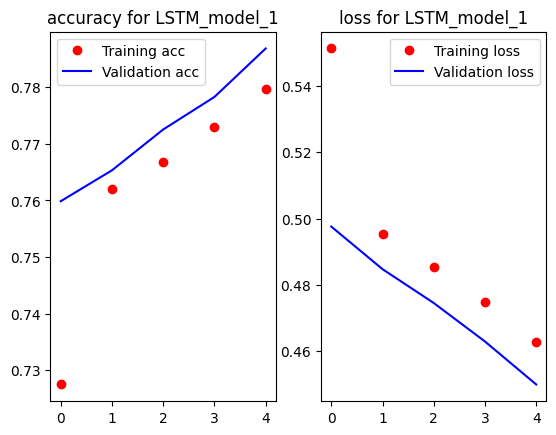

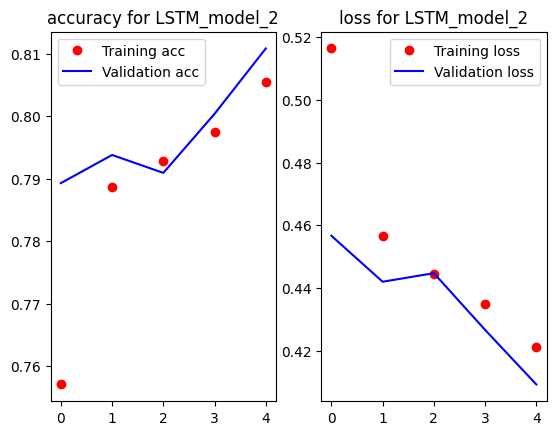

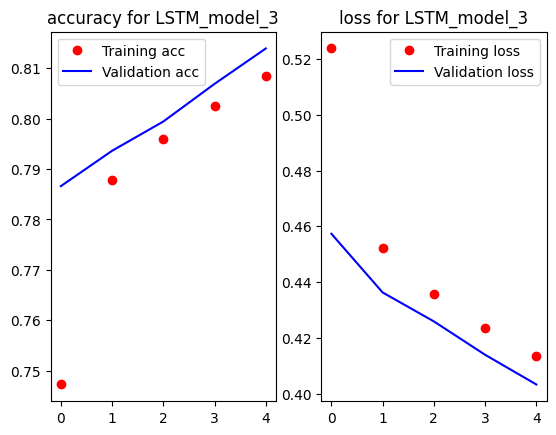

In [21]:
# plot the three models training and validation graphs
# model 1
acc = LSTM_model_1_history['accuracy']
val_acc = LSTM_model_1_history['val_accuracy']
loss = LSTM_model_1_history['loss']
val_loss = LSTM_model_1_history['val_loss']

epochs = range(len(acc))

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('accuracy for LSTM_model_1')
plt.legend()

plt.subplot(1,2,2)


plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss for LSTM_model_1')
plt.legend()

plt.show()

# model 2
acc = LSTM_model_2_history['accuracy']
val_acc = LSTM_model_2_history['val_accuracy']
loss = LSTM_model_2_history['loss']
val_loss = LSTM_model_2_history['val_loss']

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('accuracy for LSTM_model_2')
plt.legend()

plt.subplot(1,2,2)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss for LSTM_model_2')
plt.legend()

plt.show()

# model 3
acc = LSTM_model_3_history['accuracy']
val_acc = LSTM_model_3_history['val_accuracy']
loss = LSTM_model_3_history['loss']
val_loss = LSTM_model_3_history['val_loss']

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('accuracy for LSTM_model_3')
plt.legend()

plt.subplot(1,2,2)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss for LSTM_model_3')
plt.legend()

plt.show()


# Evaluating the models

In [ ]:

# LSTM_model_1 evaluation
LSTM_model_1.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.7850 - loss: 0.4556


/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'accuracy': 0.786090612411499, 'loss': 0.4533381760120392}

In [23]:
# LSTM_model_2 evaluation
LSTM_model_2.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.8106 - loss: 0.4133


{'accuracy': 0.8107218742370605, 'loss': 0.41309821605682373}

In [24]:
# LSTM_model_3 evaluation
LSTM_model_3.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8129 - loss: 0.4071


{'accuracy': 0.8127031326293945, 'loss': 0.4063315689563751}


> LSTM_model_1 is the least effective with an accuracy of 0.78. LSTM_model_2 and LSTM_model_3 both have a an accuracy of 0.81. Which is only a small improvement on the first model.
>
> This suggests that increasing the size of the encoder from 200 to 300 does make a slight difference to the accuracy. This also suggests that increasing the word embedding length from 16 to 32 has made no difference to the accuracy.
>
> LSTM_model_1 has the highest loss of the three models at 0.45. Models LSTM_model_2 and LSTM_model_3 both have a loss vaule of 0.41, which slightly better than LSTM_model_1.
>
> This suggests that increasing the size of the encoder from 200 to 300 makes the model slight better when it comes to loss, however increasing the word embedding length from 16 to 32, has little effect on the loss achieved by the model.

## Further extend the LSTM models 

## model 4

Change made for model 4: LSTM units increased from 4 to 64 and reverted word embedding length to 16.
>
> I decided to revert the embedding length back to 16 from 32 as the difference double the number made to the performance was negligible.
>
> I decided to increase the number of LSTM units from 4 to 64. This should increase the performance of the model as multiple LSTM units will allow the model to capture finer details through being able to store and process more features in the data and lead to better predictions. 64 is a good number, as I don't want the model to become overly complex and start to over-fit.

In [ ]:

# model 4
# word embedding length 16
# encoder 300
# 64 LSTM units
EMBEDDING_LEN_model_4 = 16
LSTM_model_4 = Sequential([
    encoder300, 
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN_model_4, mask_zero=True),
    LSTM(64), 
    Dense(1, activation='sigmoid')
])

LSTM_model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

LSTM_model_4_history = LSTM_model_4.fit(train_data10,
                                        validation_data=validation_data,
                                        epochs=5,
                                        verbose=1)


Epoch 1/5
    704/Unknown 229s 283ms/step - accuracy: 0.7296 - loss: 0.5241

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


704/704 ━━━━━━━━━━━━━━━━━━━━ 239s 298ms/step - accuracy: 0.7297 - loss: 0.5240 - val_accuracy: 0.7867 - val_loss: 0.4520
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 299ms/step - accuracy: 0.7910 - loss: 0.4470 - val_accuracy: 0.8135 - val_loss: 0.4010
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 299ms/step - accuracy: 0.8165 - loss: 0.4013 - val_accuracy: 0.8195 - val_loss: 0.3864
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 211s 300ms/step - accuracy: 0.8241 - loss: 0.3854 - val_accuracy: 0.8291 - val_loss: 0.3717
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 211s 300ms/step - accuracy: 0.8318 - loss: 0.3722 - val_accuracy: 0.8347 - val_loss: 0.3640


In [16]:
# Save the model and training history
LSTM_model_4.save('LSTM_model_4_review.keras')
with open('LSTM_model_4_history.json', 'w') as f:
    json.dump(LSTM_model_4_history.history, f)
    

In [15]:
# Reload the model and training history
LSTM_model_4 = tf.keras.models.load_model('LSTM_model_4_review.keras')
with open('LSTM_model_4_history.json') as f:
    LSTM_model_4_history = json.load(f)

In [18]:
# Print a summary of LSTM_model_4
LSTM_model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 16)       │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,805 (300.02 KB)

 Trainable params: 25,601 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,204 (200.02 KB)

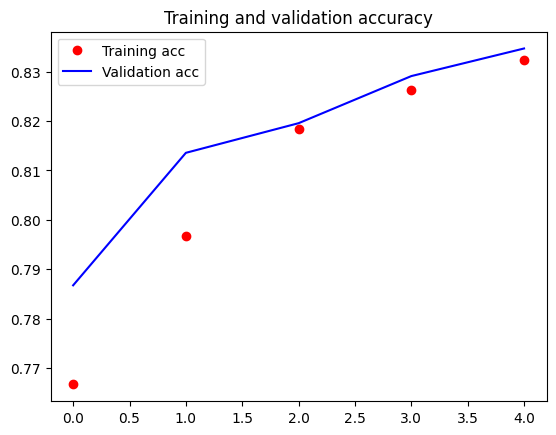

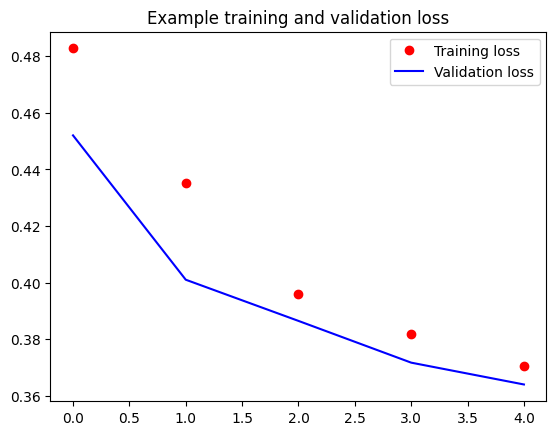

In [19]:
# Loss and Accuracy graphs for LSTM_model_4
acc = LSTM_model_4_history['accuracy']
val_acc = LSTM_model_4_history['val_accuracy']
loss = LSTM_model_4_history['loss']
val_loss = LSTM_model_4_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

## model 5

Changes made for model 5: Size of vocab increased from 300 to 1000
>
> I decided to make this change as in changing the vocab length from 200 to 300 made a slight difference in models 2 and 3. This makes sense as the more words the model knows, the less Out-Of-Vocabulary (OOV) words the model will encounter and the better it can recognize the data. 
>
> However, the change from 200 to 300 only made a small increase, 0.78 to 0.81, therefore I felt I needed to make the increase in words a large one, and decided on an increase of 700.

In [35]:
# Add new encoder with 1000 words
!mkdir encoder1000

In [36]:
# Create, save and adapt encoder with 1000 words
encoder = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder1000')

In [26]:
# Create and load its assets
encoder1000 = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder1000.load_assets('encoder1000')

In [38]:
# model 5
# word embedding length 16
# encoder 1000
# 64 LSTM units
EMBEDDING_LEN_model_5 = 16
LSTM_model_5 = Sequential([
    encoder1000, 
    Embedding(input_dim=len(encoder1000.get_vocabulary()), output_dim=EMBEDDING_LEN_model_5, mask_zero=True),
    LSTM(64), 
    Dense(1, activation='sigmoid')
])

LSTM_model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

LSTM_model_5_history = LSTM_model_5.fit(train_data10,
                                        validation_data=validation_data,
                                        epochs=5,
                                        verbose=1)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 212s 298ms/step - accuracy: 0.7676 - loss: 0.4609 - val_accuracy: 0.8473 - val_loss: 0.3537
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 298ms/step - accuracy: 0.8494 - loss: 0.3449 - val_accuracy: 0.8560 - val_loss: 0.3242
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 209s 297ms/step - accuracy: 0.8713 - loss: 0.3027 - val_accuracy: 0.8761 - val_loss: 0.2864
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 298ms/step - accuracy: 0.8803 - loss: 0.2831 - val_accuracy: 0.8795 - val_loss: 0.2807
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 210s 298ms/step - accuracy: 0.8837 - loss: 0.2766 - val_accuracy: 0.8832 - val_loss: 0.2753


In [39]:
# Save the model and training history
LSTM_model_5.save('LSTM_model_5_review.keras')
with open('LSTM_model_5_history.json', 'w') as f:
    json.dump(LSTM_model_5_history.history, f)

In [19]:
# Reload the model and training history
LSTM_model_5 = tf.keras.models.load_model('LSTM_model_5_review.keras')
with open('LSTM_model_5_history.json') as f:
    LSTM_model_5_history = json.load(f)

In [41]:
# Print a summary of LSTM_model_5
LSTM_model_5.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_7            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 16)       │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,405 (431.27 KB)

 Trainable params: 36,801 (143.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 73,604 (287.52 KB)

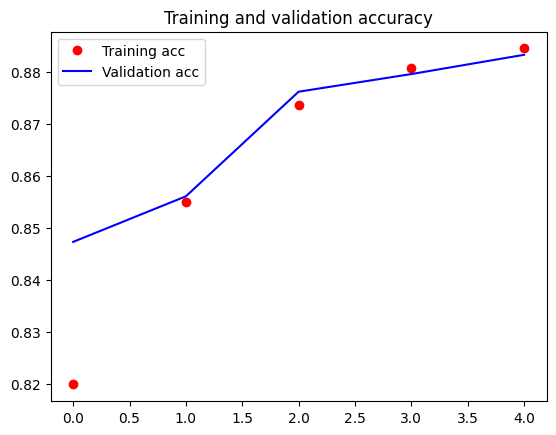

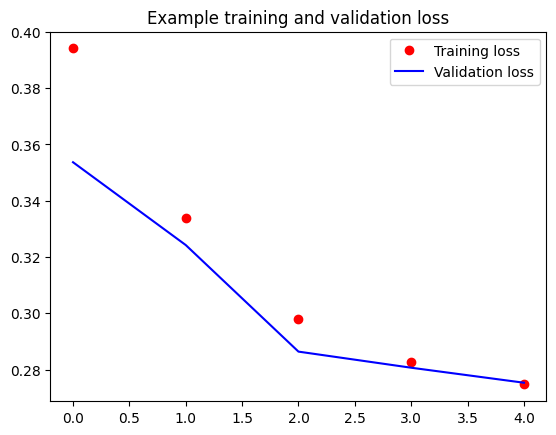

In [42]:
# Loss and Accuracy graphs for LSTM_model_5
acc = LSTM_model_5_history['accuracy']
val_acc = LSTM_model_5_history['val_accuracy']
loss = LSTM_model_5_history['loss']
val_loss = LSTM_model_5_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

## Evaluate the trained models on the test data

In [16]:
# put your code here
# Evaluate LSTM_model_4 that has 64 LSTM units
LSTM_model_4.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.8353 - loss: 0.3657


/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'accuracy': 0.8358874917030334, 'loss': 0.36487486958503723}

In [21]:
# Evaluate LSTM_model_5 that has 64 LSTM units and 1000 vocab
LSTM_model_5.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8819 - loss: 0.2776


{'accuracy': 0.8830468654632568, 'loss': 0.2767849266529083}

## Compare and comment on the results


>
> My fourth model sees an increase in accuracy from 0.81 to 0.84, and a decrease in loss from 0.41 to 0.36.
>
> My fifth model sees an increase in accuracy from 0.84 in the fourth model to 0.88 and a decrease in loss from 0.36 in the fourth model to 0.28.
>
> The most significant improvement in the decrease in loss is from model 4 to model 5 (0.38 to 0.28) a drop of 0.09, by far the largest decrease between any of the models. This suggests that giving the model a significantly larger vocabulary makes it significantly easier to make correct predictions. This is because the model will encounter far fewer OOV words and will be able to interpret the data more accurately.
>
> These improvements line up with my original thinking, that increasing the number of LSTM units will allow the model to capture the finer details and increasing the number of words in the model's vocabulary will improve the models understanding of these details. These have led to both an increase in the accuracy and a decrease in the loss.
>
> I did further experiment with the number of units and the size of the vocabulary, but found that above 64 units and 1000 vocab made such a small difference (the accuracy increased by 0.01 and the loss decreased by 0.01 with 128 LSTM units and 2000 words of vocabulary), that it wasn't worth the additional computational resources.
>
> The model may have stopped improving with 128 units as it got overly complex the additional units weren't required. As for the vocabulary size increase to 2000 may not have made a difference as the model may have started to over-fit, due to how specific about the training data might have become.